similarity search tutorial: https://www.youtube.com/watch?v=Rj9gSsB7kdw

k-means clustering tutorial: [How to cluster images based on visual similarity](https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from PIL import Image
import base64
import io
from io import BytesIO
import cv2

from scipy import misc
from math import sqrt
from numpy import ndarray

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from keras.preprocessing.image import load_img 

from sklearn.cluster import KMeans

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import the training dataset
solana_train = pd.read_csv("drive/My Drive/opencampus/DL course - NFT classifier/datasets/solana_train.csv")
#solana_train.head()
solana_train=solana_train['img']
solana_train.shape

(5996,)

In [5]:
# setup parameters
x = 128 # desired size of image
y=x*x*3

# number of pictures on which the model will be trained 
quantity = len(solana_train) #the whole dataset
# and the one that will be tested on the dataset
pic_num = 20

# first we're building an image similarity search on the pixels comparison

original img size:  (500, 500)
resized img size:  49152
img_test shape:  (49152, 1)


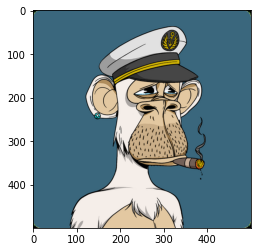

In [6]:
# import test image
solana_test = pd.read_csv("drive/My Drive/opencampus/DL course - NFT classifier/datasets/apes_test.csv")
#apes_test.head()

# retreive test image from dataset
img_test=solana_test['img'][pic_num]
img_data = base64.b64decode(img_test[1:])
img_test = Image.open(io.BytesIO(img_data))
print("original img size: ",img_test.size)
img_test = np.array(img_test)
plt.imshow(img_test)

# resize the test image
img_test = cv2.resize(img_test, (x,x))
print("resized img size: ",img_test.size)
# save resized image for later visualization
testimage = img_test
# reshape it for later use
img_test = np.reshape(img_test, [y,1],order="F")

print("img_test shape: ",img_test.shape)

In [7]:
# loop through images in dataset and save it in the "dataset"-array
dataset = np.array([])

for i in range(quantity):
  save_data = dataset
  b64_img = solana_train[i][1:]
  img_data = base64.b64decode(b64_img)
  img = Image.open(io.BytesIO(img_data))
  img = np.array(img)
  #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # apply gray filter
  img = cv2.resize(img, (x,x))
  img = np.reshape(img, [1,img.size], order="F")
  i_save = i+1

  for k in range(len(img)):
    dataset = np.append(dataset,img)
  
print(i_save)

#reshape the dataset to make it comparable to the test images
dataset = np.reshape(dataset,[y,i_save],order="F")
print(dataset.shape)
print(dataset)

5996
(49152, 5996)
[[255.  11. 168. ... 244.  36.  70.]
 [255.   3. 168. ... 244.  36.  70.]
 [255.   0. 168. ... 244.  36.  69.]
 ...
 [  0.  43. 152. ... 197.  22.  19.]
 [  0.  52. 152. ... 197.  21.  17.]
 [  0.  49. 152. ... 197.  27.  17.]]


In [8]:
#the function to compute the distance between the vectors of the images
def euclidean_distance(row1,row2):
  distance = 0.0
  for i in range(len(row1)):
    distance = distance + (row1[i] - row2[i])**2
  return sqrt(distance)

#print("img3 len: ",len(dataset))
#print("img_test len: ",len(img_test))

In [9]:
#compare the test picture to every picture in the dataset
dist = np.zeros(quantity)

for i in range(quantity):
  selectedimg = dataset[0:y,i]
  dist[i] = euclidean_distance(img_test,selectedimg)

print("Euclidean: ", dist)
print("Minimum dist: ", min(dist))
mindist = np.argmin(dist)
print("Index of min dist: ", mindist)

Euclidean:  [29532.26609998 25082.85414382 22498.24319808 ... 28831.51222187
 21618.5322351  23549.3769132 ]
Minimum dist:  12914.887494670636
Index of min dist:  1614


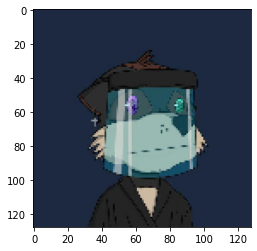

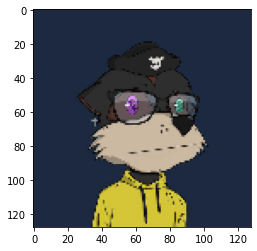

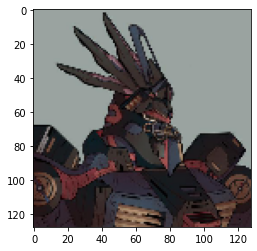

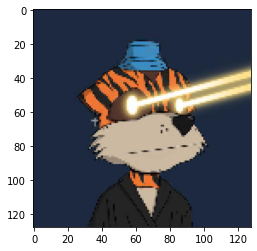

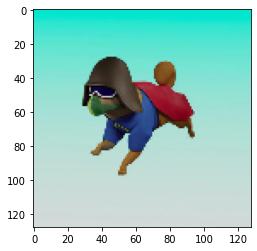

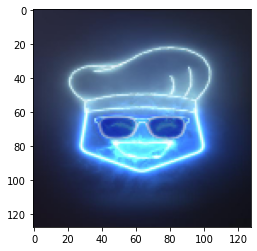

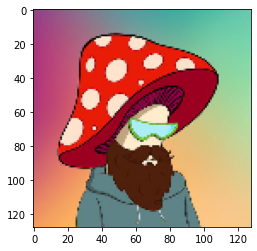

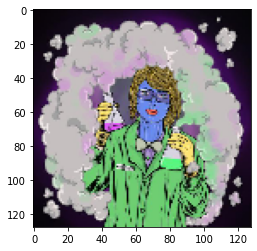

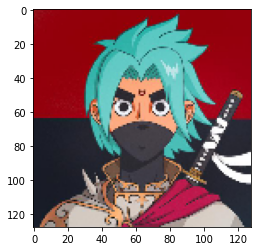

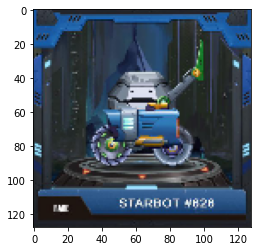

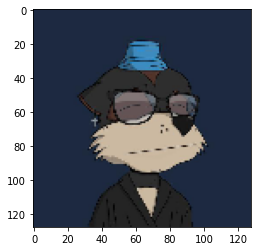

In [ ]:
#pick the picture that's most similar and visualize it


for i in range(10):
  img_data = base64.b64decode(solana_train[mindist][1:])
  img = Image.open(io.BytesIO(img_data))
  img = np.array(img)
  img = cv2.resize(img,(x,x))
  plt.figure()
  plt.imshow(img)
  dist = np.delete(dist, mindist)
  mindist = np.argmin(dist)

plt.figure()
plt.imshow(testimage)

#### we suspect the pixels comparison method to be biased by the pictures background on which it gives too much attention comparatively to other image features.

In [ ]:
# performs k-means clustering on the images
kmeans = KMeans(n_clusters=40, random_state=22)
kmeans.fit(dataset)

KMeans(n_clusters=40, random_state=22)

In [ ]:
# holds the cluster id and the images { id: [images] }
groups = {}
for cluster in kmeans.labels_:
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(cluster)
    else:
        pass

In [ ]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

# we will use VGG16 model with pre-trained weight from imagenet dataset and run our image similarity search engine after passing images through our CNN. 

In [ ]:
# set the desired size of image
x = 128
y=x*x*3

# upload pretrained model
vgg = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(x,x,3))
vgg.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

original img shape:  (500, 500, 3)
vgg input img shape:  (1, 128, 128, 3)
vgg output img_test shape:  (1, 4, 4, 512)
img_test shape:  (8192, 1)


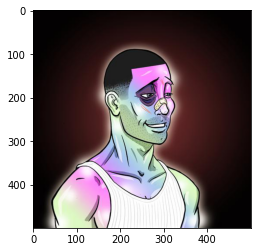

In [ ]:
# import test image and pass it through vgg16
solana_test = pd.read_csv("drive/My Drive/opencampus/DL course - NFT classifier/datasets/solana_test.csv")

# retreive test image from dataset
img_test = solana_test['img'][pic_num]
img_data = base64.b64decode(img_test[1:])
img_test = Image.open(io.BytesIO(img_data))
img_test = np.array(img_test)
print("original img shape: ",img_test.shape)
# visualize image
plt.imshow(img_test)
# transform image to fit vgg input
img_test = img_test[:,:,:3]
img_test = cv2.resize(img_test,(x,x))
img_test = img_test.reshape(1,x,x,3)
#img_test = preprocess_input(img_test)
print("vgg input img shape: ",img_test.shape)
img_test = vgg.predict(img_test)
print("vgg output img_test shape: ",img_test.shape)

# reshape vgg output to fit similarity comparison
img_test = np.reshape(img_test, [img_test.size, 1],order="F")
print("img_test shape: ",img_test.shape)

In [ ]:
# upload dataset
solana_train = pd.read_csv("drive/My Drive/opencampus/DL course - NFT classifier/datasets/solana_train.csv")

vgg_dataset = np.array([])
# loop through each image in the dataset
for i in range(quantity):
  b64_img = solana_train.img.loc[i][1:]
  img_data = base64.b64decode(b64_img)
  img = Image.open(io.BytesIO(img_data))
  img = np.array(img)
  # transform image to fit vgg input
  img = img[:,:,:3]
  img = cv2.resize(img,(x,x))
  img = img.reshape(1, x,x,3)
  #pass the image in vgg16 model
  img = vgg.predict(img)
  img = np.reshape(img, [1,img.size],order="F")
  i_save = i+1

  for k in range(len(img)):
    vgg_dataset = np.append(vgg_dataset, img)
  
#reshape the dataset to make it comparable to the test image
vgg_dataset = np.reshape(vgg_dataset,[img.size, i_save],order="F")
print(len(vgg_dataset))
print(vgg_dataset.shape)
print(vgg_dataset)

8192
(8192, 5996)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         4.09667587]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         9.74074554 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [ ]:
#the function to compute the distance between the vectors of the images
def euclidean_distance(row1,row2):
  distance = 0.0
  for i in range(len(row1)):
    distance = distance + (row1[i] - row2[i])**2
  return np.sqrt(distance)

# print("img3 len: ",len(vgg_dataset))
# print("img_test len: ",len(img_test))

In [ ]:
#compare the test picture to every vgg processed picture in the dataset
dist = np.zeros(quantity)

for i in range(quantity):
  selectedimg = vgg_dataset[0:y,i]
  ed = euclidean_distance(img_test,selectedimg)
  # this is a sequence of numbers and we want a single number
  dist[i] = np.nanmean(ed) # take the mean of array ignoring nan

print("Euclidean: ", dist)
print("Minimum dist: ", min(dist))
mindist = np.argmin(dist)
print("Index of min dist: ", mindist)

Euclidean:  [1591.12768555 1299.5723877  1054.82299805 ... 1492.23535156 1267.71520996
 1295.31054688]
Minimum dist:  990.7431640625
Index of min dist:  4600


The test-image is most similar to the following picture: 


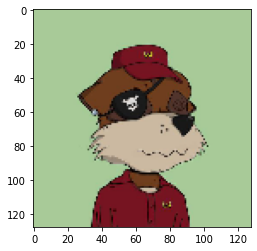

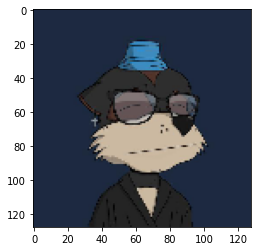

In [ ]:
# import test image and pass it through vgg16
solana_test = pd.read_csv("drive/My Drive/opencampus/DL course - NFT classifier/datasets/solana_test.csv")
#apes_test.head()

# retreive test image from dataset
img_test = solana_test['img'][pic_num]
img_data = base64.b64decode(img_test[1:])
img_test = Image.open(io.BytesIO(img_data))
img_test = np.array(img_test)

#pick the picture that's most similar and compare it
img_data = base64.b64decode(solana_train.img.loc[mindist][1:])
img = Image.open(io.BytesIO(img_data))
img = np.array(img)
img = cv2.resize(img,(x,x))
#img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

print("The test-image is most similar to the following picture: ")
plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(testimage)

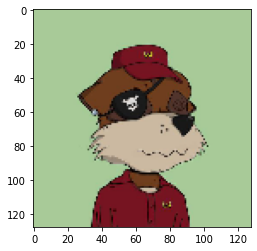

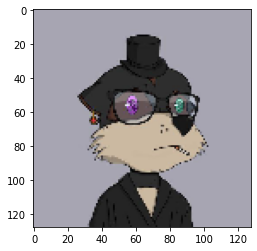

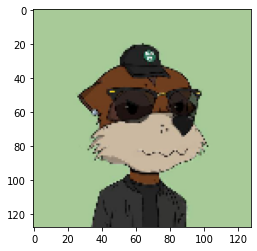

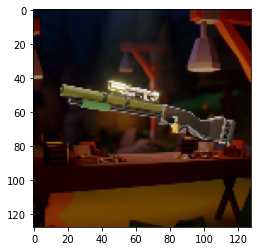

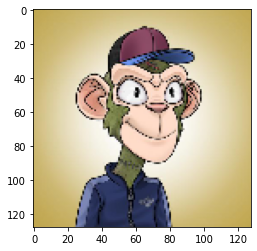

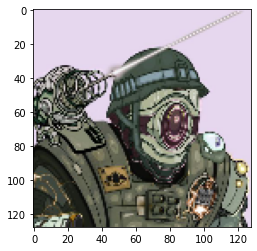

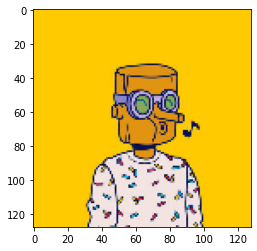

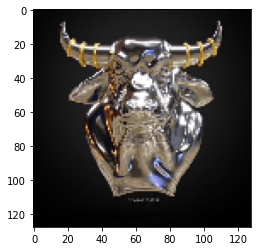

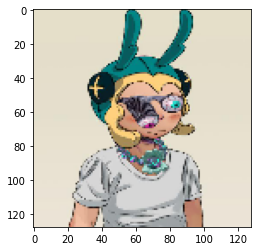

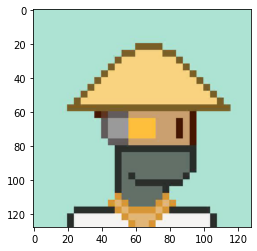

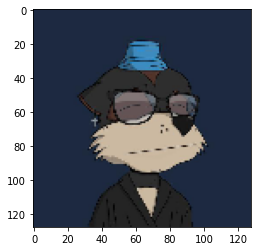

In [ ]:
# see a comparision to the 10 most similar pictures of the vgg model

for i in range(10):
  img_data = base64.b64decode(solana_train.img.loc[mindist][1:])
  img = Image.open(io.BytesIO(img_data))
  img = np.array(img)
  img = cv2.resize(img,(x,x))
  plt.figure()
  plt.imshow(img)
  dist = np.delete(dist, mindist)
  mindist = np.argmin(dist)

plt.figure()
plt.imshow(testimage)

Is the result the same with and without vgg16 processing?

In [ ]:
# show the 10 nearest images, both for pixel to pixel and for vgg


In [ ]:
# try to check what the model gives as a result of a test image outside of the dataset (e.g apes)


In [ ]:
# performs k-means clustering on the images
kmeans = KMeans(n_clusters=40, random_state=22)
kmeans.fit(vgg_dataset)

KMeans(n_clusters=40, random_state=22)

In [ ]:
# holds the cluster id and the images { id: [images] }
groups = {}
for cluster in kmeans.labels_:
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(cluster)
    else:
        pass

In [ ]:
groups[0]

[0]

In [ ]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = Image.open(io.BytesIO(file))
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

UnidentifiedImageError: ignored

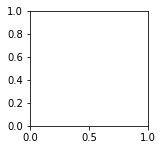

In [ ]:
view_cluster(0)

### what's the best number of clusters for the 100 solana collections dataset?

running it takes lots of time.

result is: 

In [ ]:
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(1,100))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(vgg_output)
    
    sse.append(km.inertia_)

In [ ]:
# visualize the number of clusters
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

In [ ]:
# identify which cluster the test image comes from

# pickup the closest image from a different cluster


In [ ]:
# pickup the closest image from a specific cluster?


# save the pretrained model + dataset on huggingface platform

In [ ]:
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 101 kB 4.2 MB/s 
     |████████████████████████████████| 596 kB 49.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# login to huggingface
from huggingface_hub import notebook_login
notebook_login()

ModuleNotFoundError: ignored

In [ ]:
# save the trained model to huggingface
vgg.push_to_hub("nft similarity search engine", organization="DemocracyStudio")
# save the processed dataset that goes with the model
vgg_dataset.push_to_hub("nft similarity search engine", organization="DemocracyStudio")